In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.1


In [3]:
import tensorflow as tf
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from math import sqrt
from numpy.random import seed

from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow import keras
from keras.layers import Dense
from keras import layers
from keras.layers import LSTM

In [4]:
seed(1)
tf.random.set_seed(1234)

In [5]:
# fix random seed for reproducibility
np.random.seed(7)

In [6]:
df = pd.read_csv('../../Data/data_preprocessed/predicition_data/P_agg_data_for_prediction.csv', engine='python', skipfooter=3)
df

,measurement,appliance,value,timestamp
0,Electricity,P_agg,105.183,1661990400
1,Electricity,P_agg,105.224,1661990430
2,Electricity,P_agg,106.171,1661990460
3,Electricity,P_agg,105.903,1661990490
4,Electricity,P_agg,105.970,1661990520
...,...,...,...,...
1049310,Electricity,P_agg,1029.913,1693526160
1049311,Electricity,P_agg,1030.499,1693526190
1049312,Electricity,P_agg,1030.900,1693526220
1049313,Electricity,P_agg,1028.714,1693526250


(array([19236., 19297., 19358., 19417., 19478., 19539., 19601.]),
 [Text(19236.0, 0, '2022-09-01 00:00:00'),
  Text(19297.0, 0, '2022-11-01 00:00:00'),
  Text(19358.0, 0, '2023-01-01 00:00:00'),
  Text(19417.0, 0, '2023-03-01 00:00:00'),
  Text(19478.0, 0, '2023-05-01 00:00:00'),
  Text(19539.0, 0, '2023-07-01 00:00:00'),
  Text(19601.0, 0, '2023-09-01 00:00:00')])

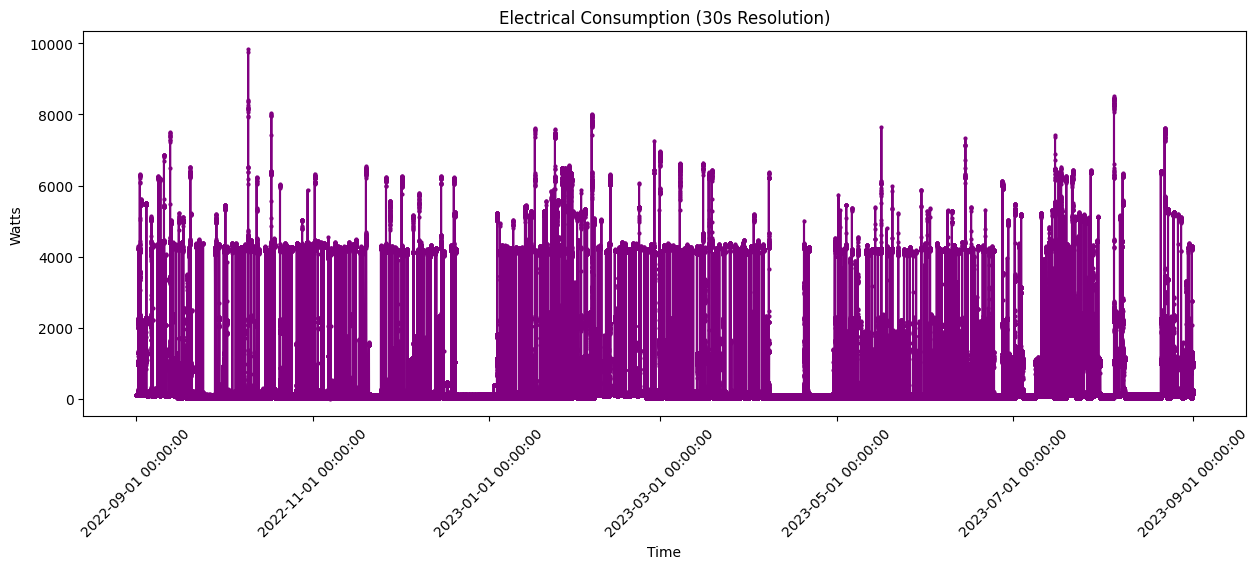

In [7]:
import matplotlib.dates as mdates
# Convert timestamp to datetime (assuming it's in seconds since epoch)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# Plot the 30-second resolution data
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], linestyle='-', marker='o', markersize=2, color='purple')
plt.title('Electrical Consumption (30s Resolution)')
plt.xlabel('Time')
plt.ylabel('Watts')
# Format x-axis to show date and time
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)


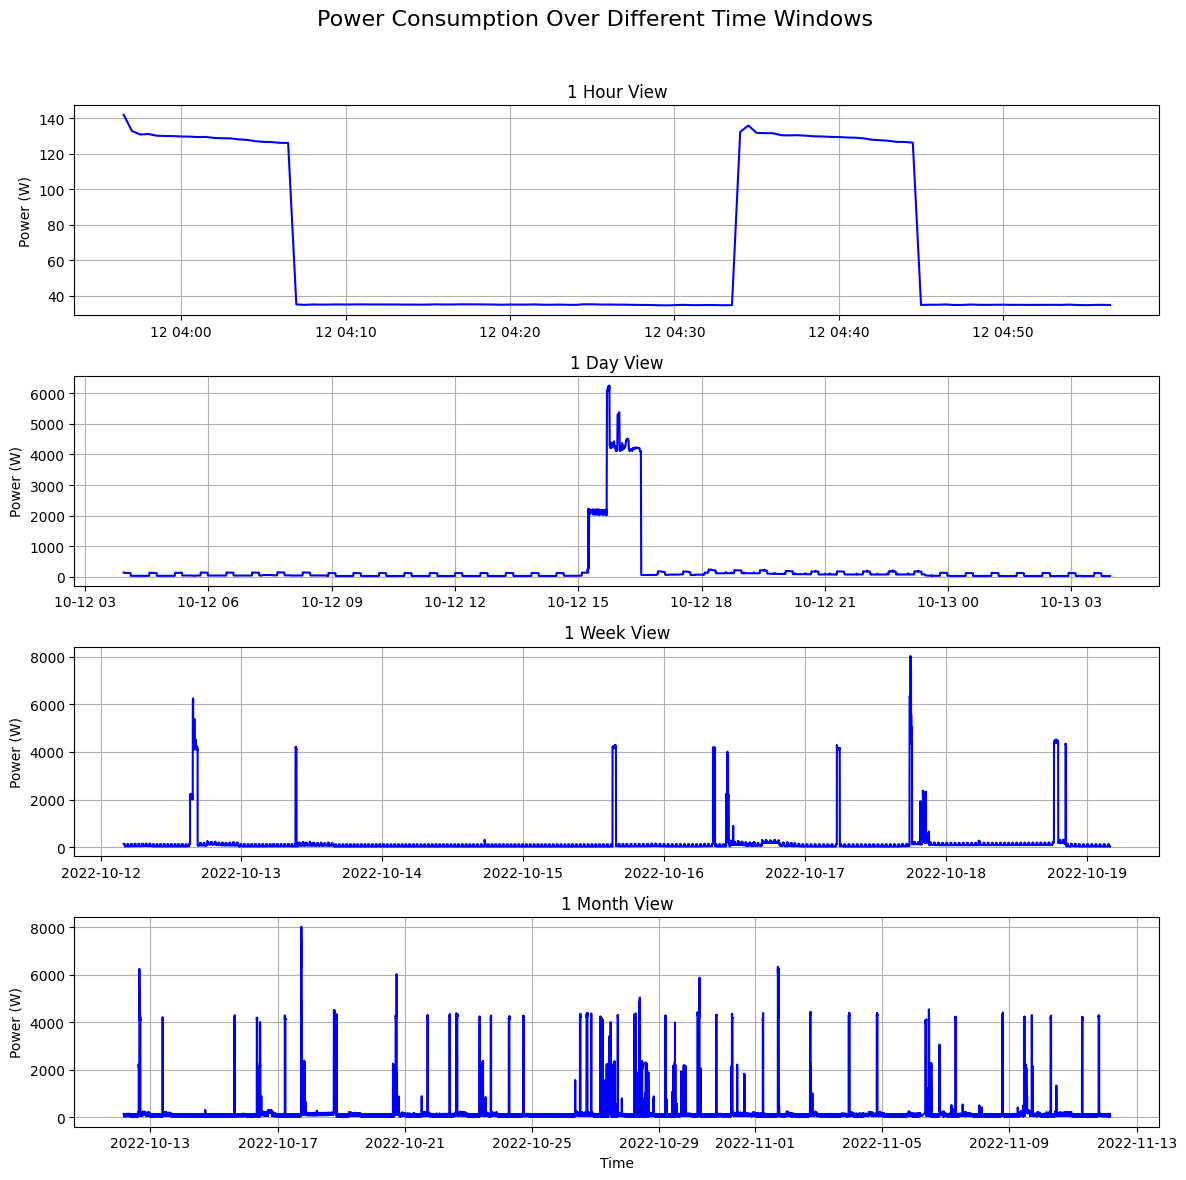

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert timestamp column to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('datetime', inplace=True)

# Start time
start_time = pd.to_datetime(1665546990, unit='s')

# Time ranges
ranges = {
    '1 Hour': start_time + pd.Timedelta(hours=1),
    '1 Day': start_time + pd.Timedelta(days=1),
    '1 Week': start_time + pd.Timedelta(weeks=1),
    '1 Month': start_time + pd.DateOffset(months=1),
}

# Plot setup
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=False)
fig.suptitle('Power Consumption Over Different Time Windows', fontsize=16)

# Generate subplots
for ax, (label, end_time) in zip(axes, ranges.items()):
    df_window = df.loc[start_time:end_time]
    ax.plot(df_window.index, df_window['value'], color='blue')
    ax.set_title(f"{label} View")
    ax.set_ylabel("Power (W)")
    ax.grid(True)

axes[-1].set_xlabel("Time")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [202]:
# Convert 'timestamp' to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Set datetime as index for resampling
df.set_index('datetime', inplace=True)

# Resample to daily sum of 'value' in kilowatts (kWh)
daily_df = df.resample('1d').sum(numeric_only=True)
daily_df['value'] = daily_df['value']/1000 # Convert from Wh to kWh


# Reset index to turn datetime back into a column
daily_df = daily_df.reset_index()

# Add iteration column
daily_df['iteration'] = range(len(daily_df))

# Reorder columns
daily_df = daily_df[['iteration', 'datetime', 'value']]

# Final result
print(daily_df)

     iteration   datetime        value
0            0 2022-09-01  1075.340479
1            1 2022-09-02  3319.990097
2            2 2022-09-03  2197.876380
3            3 2022-09-04  2637.341984
4            4 2022-09-05   336.764387
..         ...        ...          ...
360        360 2023-08-27   819.087481
361        361 2023-08-28  1783.522167
362        362 2023-08-29  2796.125353
363        363 2023-08-30  2478.858460
364        364 2023-08-31  1331.943858

[365 rows x 3 columns]


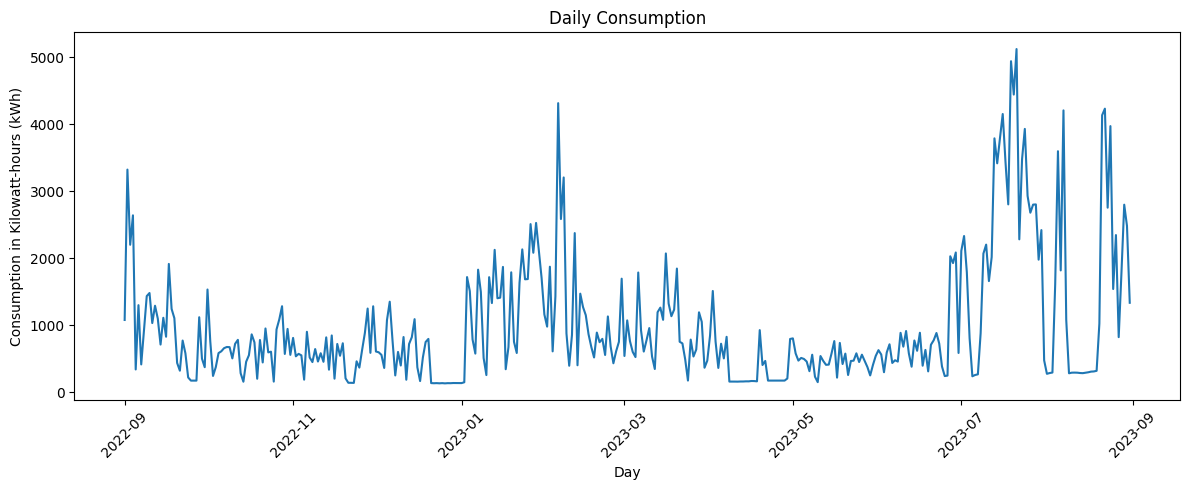

In [144]:
# Plot only the 'value' column against the 'datetime'
plt.figure(figsize=(12, 5))
plt.plot(daily_df['datetime'], daily_df['value'])

# Format the x-axis ticks to show dates
plt.xlabel('Day')
plt.ylabel('Consumption in Kilowatt-hours (kWh)')
plt.title("Daily Consumption")

# Rotate and format date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [203]:
tseries= daily_df.drop('datetime', axis=1)
tseries = tseries.drop('iteration', axis=1)
df=pd.DataFrame(tseries)
df

,value
0,1075.340479
1,3319.990097
2,2197.876380
3,2637.341984
4,336.764387
...,...
360,819.087481
361,1783.522167
362,2796.125353
363,2478.858460


In [204]:
df=np.array(df)
df

array([[1075.34047867],
       [3319.9900965 ],
       [2197.87638   ],
       [2637.341984  ],
       [ 336.7643875 ],
       [1296.32224117],
       [ 411.8516815 ],
       [ 914.7721935 ],
       [1431.990737  ],
       [1477.764949  ],
       [1029.332412  ],
       [1287.9611885 ],
       [1095.51200567],
       [ 708.4424925 ],
       [1108.0729035 ],
       [ 825.25322833],
       [1911.989895  ],
       [1240.53936   ],
       [1102.760968  ],
       [ 434.97046567],
       [ 318.11554   ],
       [ 767.956168  ],
       [ 578.5033855 ],
       [ 217.0700745 ],
       [ 170.1778805 ],
       [ 169.836138  ],
       [ 170.119325  ],
       [1116.213181  ],
       [ 497.3990055 ],
       [ 370.3458465 ],
       [1529.9664925 ],
       [ 760.742715  ],
       [ 239.7076885 ],
       [ 370.993554  ],
       [ 581.1008815 ],
       [ 607.648787  ],
       [ 654.570713  ],
       [ 671.936407  ],
       [ 669.8646645 ],
       [ 501.640471  ],
       [ 719.4956045 ],
       [ 778.661

In [205]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]


In [197]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [206]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train


array([[2.26216603e-01],
       [7.62898919e-01],
       [4.94608232e-01],
       [5.99681833e-01],
       [4.96274712e-02],
       [2.79052022e-01],
       [6.75803947e-02],
       [1.87825685e-01],
       [3.11489549e-01],
       [3.22433890e-01],
       [2.15216349e-01],
       [2.77052945e-01],
       [2.31039495e-01],
       [1.38493486e-01],
       [2.34042730e-01],
       [1.66422235e-01],
       [4.26254481e-01],
       [2.65714669e-01],
       [2.32772678e-01],
       [7.31079579e-02],
       [4.51686432e-02],
       [1.52722850e-01],
       [1.07425822e-01],
       [2.10092759e-02],
       [9.79763245e-03],
       [9.71592386e-03],
       [9.78363218e-03],
       [2.35989022e-01],
       [8.80342489e-02],
       [5.76565975e-02],
       [3.34914967e-01],
       [1.50998157e-01],
       [2.64217942e-02],
       [5.78114605e-02],
       [1.08046867e-01],
       [1.14394313e-01],
       [1.25613065e-01],
       [1.29765099e-01],
       [1.29269758e-01],
       [8.90483580e-02],


In [207]:
test = scaler.fit_transform(test)
test

array([[9.63665658e-02],
       [1.10049391e-01],
       [1.32220906e-01],
       [9.99891283e-02],
       [2.98894066e-02],
       [6.43482322e-04],
       [2.06570054e-03],
       [3.66741159e-01],
       [3.45904173e-01],
       [3.78239728e-01],
       [7.12128913e-02],
       [3.83337729e-01],
       [4.28578856e-01],
       [3.17868712e-01],
       [1.16738240e-01],
       [0.00000000e+00],
       [3.89847790e-03],
       [5.92543098e-03],
       [1.31665706e-01],
       [3.74928869e-01],
       [4.02363203e-01],
       [2.90898751e-01],
       [3.64407284e-01],
       [7.27082965e-01],
       [6.50785801e-01],
       [7.27828446e-01],
       [8.01471633e-01],
       [6.55313970e-01],
       [5.25297105e-01],
       [9.62832860e-01],
       [8.60922092e-01],
       [1.00000000e+00],
       [4.18453514e-01],
       [6.63396587e-01],
       [7.55951337e-01],
       [5.51230852e-01],
       [4.99884402e-01],
       [5.24568472e-01],
       [5.25176135e-01],
       [3.56364850e-01],


In [208]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_test, Y_test = create_dataset(test, lookback)

In [209]:
print("X training=",X_train)
print("Y training=",Y_train)

X training= [[0.2262166  0.76289892 0.49460823 0.59968183 0.04962747]
 [0.76289892 0.49460823 0.59968183 0.04962747 0.27905202]
 [0.49460823 0.59968183 0.04962747 0.27905202 0.06758039]
 ...
 [0.18678673 0.10695974 0.05949444 0.1530843  0.1161764 ]
 [0.10695974 0.05949444 0.1530843  0.1161764  0.18056183]
 [0.05949444 0.1530843  0.1161764  0.18056183 0.06300776]]
Y training= [2.79052022e-01 6.75803947e-02 1.87825685e-01 3.11489549e-01
 3.22433890e-01 2.15216349e-01 2.77052945e-01 2.31039495e-01
 1.38493486e-01 2.34042730e-01 1.66422235e-01 4.26254481e-01
 2.65714669e-01 2.32772678e-01 7.31079579e-02 4.51686432e-02
 1.52722850e-01 1.07425822e-01 2.10092759e-02 9.79763245e-03
 9.71592386e-03 9.78363218e-03 2.35989022e-01 8.80342489e-02
 5.76565975e-02 3.34914967e-01 1.50998157e-01 2.64217942e-02
 5.78114605e-02 1.08046867e-01 1.14394313e-01 1.25613065e-01
 1.29765099e-01 1.29269758e-01 8.90483580e-02 1.41136219e-01
 1.55282375e-01 3.62636219e-02 5.86234166e-03 7.71296843e-02
 1.00400617e

In [210]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [211]:
X_train.shape

(286, 1, 5)

In [215]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

# Model Definition
model = Sequential([
    LSTM(80, activation='linear', return_sequences=True, input_shape=(1, lookback)),
    Dropout(0.3),
    LSTM(80, activation='linear'),
    Dropout(0.3),
    Dense(1)  # Assuming regression output
])

# Compile the Model
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model
history=model.fit(
    X_train, Y_train,
    epochs=35,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
    validation_split=0.2
)

Epoch 1/35
4/4 [==============================] - 2s 78ms/step - loss: 0.0447 - val_loss: 0.0064
Epoch 2/35
4/4 [==============================] - 0s 21ms/step - loss: 0.0382 - val_loss: 0.0043
Epoch 3/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0321 - val_loss: 0.0028
Epoch 4/35
4/4 [==============================] - 0s 20ms/step - loss: 0.0267 - val_loss: 0.0022
Epoch 5/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0220 - val_loss: 0.0026
Epoch 6/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0183 - val_loss: 0.0044
Epoch 7/35
4/4 [==============================] - 0s 20ms/step - loss: 0.0178 - val_loss: 0.0067
Epoch 8/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0181 - val_loss: 0.0082
Epoch 9/35
4/4 [==============================] - 0s 19ms/step - loss: 0.0173 - val_loss: 0.0078
Epoch 10/35
4/4 [==============================] - 0s 20ms/step - loss: 0.0174 - val_loss: 0.0066
Epoch 11/35
4/4 [============

dict_keys(['loss', 'val_loss'])


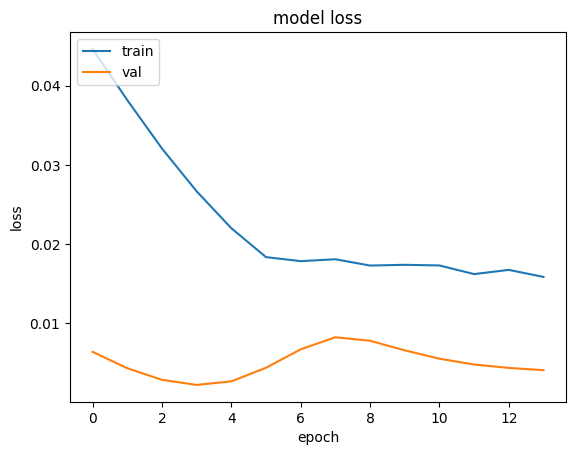

In [216]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [217]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [218]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

In [219]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (valScore))

Train Score: 671.38 RMSE
Test Score: 1712.18 RMSE


In [220]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [221]:
# Test predictions
testpredPlot = np.empty_like(df)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = testpred

In [222]:
Y_test=Y_test.reshape(-1)
Y_test.shape
Y_test=pd.Series(Y_test)

In [223]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)
predictions

0      634.151001
1      616.482178
2      600.770203
3      659.560425
4      703.498108
         ...     
62    1101.081909
63    1039.328491
64     904.098145
65     886.645264
66     857.113525
Length: 67, dtype: float32

C:\Users\Ghada\AppData\Local\Temp\ipykernel_28396\682194490.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_original.resample('1H').sum(numeric_only=True)


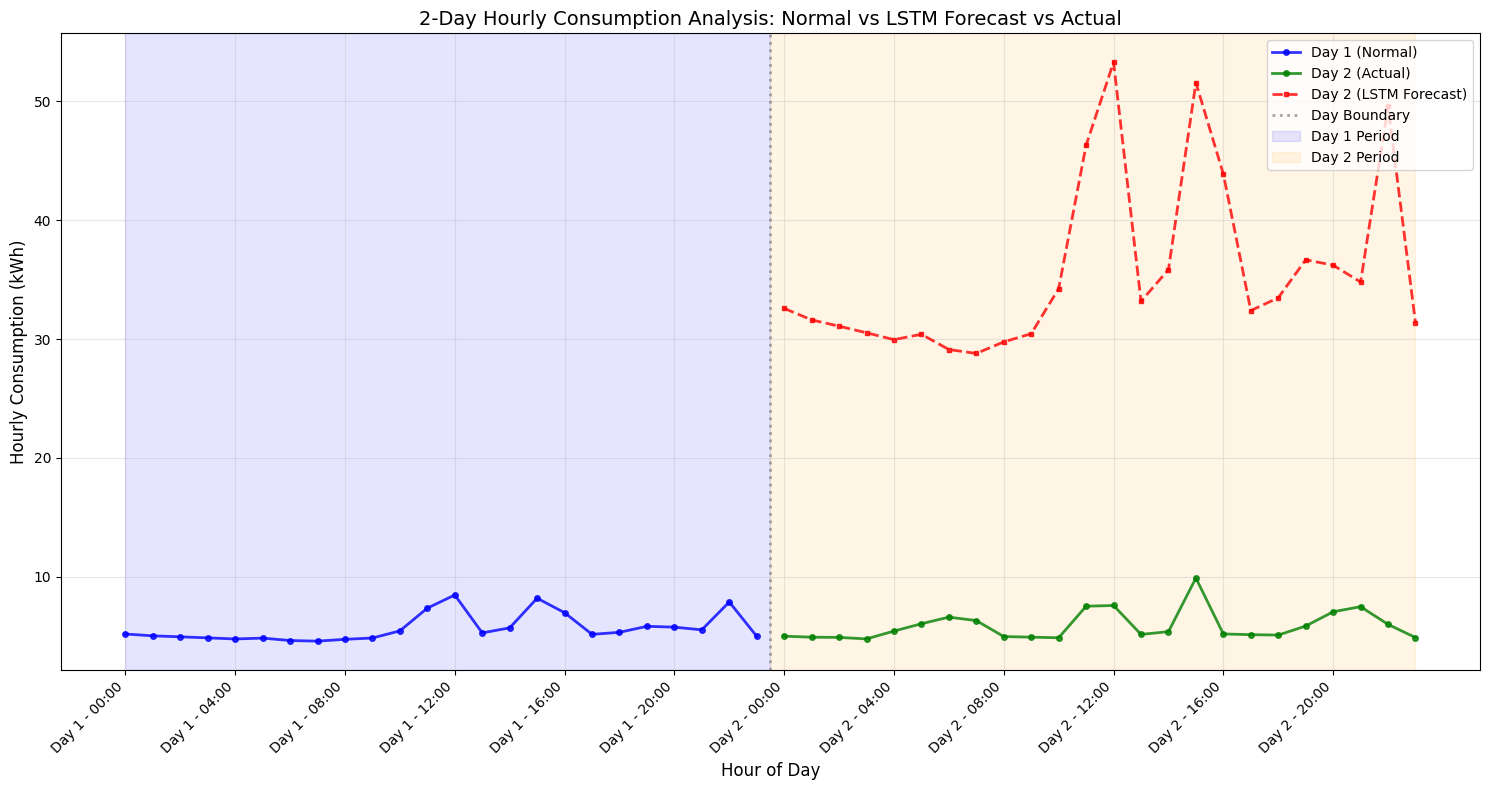


2-Day Hourly Consumption Analysis

Day 1 (Normal Operation):
  - Total consumption: 135.91 kWh
  - Average hourly: 5.663 kWh
  - Peak hour: 8.452 kWh
  - Min hour: 4.565 kWh

Day 2 (Actual vs LSTM Forecast):
  - Actual total: 140.53 kWh
  - LSTM Forecast total: 857.11 kWh
  - Total error: 716.59 kWh
  - Average hourly error: 29.858 kWh
  - RMSE: 30.566 kWh

LSTM Model Performance Metrics:
  - Mean Absolute Error (MAE): 29.8577 kWh
  - Mean Absolute Percentage Error (MAPE): 518.63%
  - Root Mean Square Error (RMSE): 30.5664 kWh

Peak Consumption Analysis:
  - Day 1 peak at hour: 12:00
  - Day 2 actual peak at hour: 15:00

Hourly Forecast vs Actual (First 12 hours):
  Hour  0: Actual=4.9866 kWh, Forecast=32.5778 kWh, Error=553.3%
  Hour  1: Actual=4.8963 kWh, Forecast=31.6115 kWh, Error=545.6%
  Hour  2: Actual=4.8809 kWh, Forecast=31.0808 kWh, Error=536.8%
  Hour  3: Actual=4.7528 kWh, Forecast=30.5260 kWh, Error=542.3%
  Hour  4: Actual=5.4132 kWh, Forecast=29.9464 kWh, Error=453.2%
 

In [227]:
# Create hourly consumption data for 2-day detailed analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert original data to hourly resolution
df_original = pd.read_csv('../../Data/data_preprocessed/predicition_data/fridge_data_for_prediction.csv', engine='python', skipfooter=3)
df_original['datetime'] = pd.to_datetime(df_original['timestamp'], unit='s')
df_original.set_index('datetime', inplace=True)

# Resample to hourly consumption (kWh)
hourly_df = df_original.resample('1H').sum(numeric_only=True)
hourly_df['value'] = hourly_df['value'] / 1000  # Convert from Wh to kWh
hourly_df = hourly_df.reset_index()

# Get the last 48 hours (2 days) of data
last_48_hours = hourly_df.iloc[-48:].copy()

# Split into Day 1 (first 24 hours) and Day 2 (last 24 hours)
day1_hours = last_48_hours.iloc[:24].copy()
day2_hours = last_48_hours.iloc[24:].copy()

# Generate LSTM predictions for Day 2 hourly data
# Method 1: Use daily prediction and distribute hourly based on Day 1 pattern
if len(predictions) > 0:
    # Get the latest daily prediction from LSTM
    latest_daily_pred = predictions.iloc[-1] if hasattr(predictions, 'iloc') else predictions[-1]
    
    # Calculate Day 1 hourly pattern (normalized)
    day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
    
    # Apply the pattern to the predicted daily consumption
    day2_forecast = latest_daily_pred * day1_hourly_pattern
else:
    # Fallback if no predictions available
    day2_forecast = day2_hours['value'].values * (1 + np.random.normal(0, 0.1, 24))

# Alternative Method 2: Multi-step ahead prediction using the trained model
# Uncomment this section if you want to use multi-step prediction instead
"""
# Prepare the last sequence from daily data for multi-step prediction
last_sequence = df[-lookback:].reshape(1, 1, lookback)
last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1)).reshape(1, 1, lookback)

# Generate 24 hourly predictions (assuming model can be adapted for hourly)
daily_pred_scaled = model.predict(last_sequence_scaled)
daily_pred = scaler.inverse_transform(daily_pred_scaled)[0][0]

# Distribute the daily prediction across 24 hours using Day 1 pattern
day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
day2_forecast = daily_pred * day1_hourly_pattern
"""

# Create the plot
plt.figure(figsize=(15, 8))

# Create hour labels for x-axis
day1_hours_labels = [f"Day 1 - {i:02d}:00" for i in range(24)]
day2_hours_labels = [f"Day 2 - {i:02d}:00" for i in range(24)]
all_hours_labels = day1_hours_labels + day2_hours_labels

# X-axis positions
x_positions = list(range(48))

# Plot Day 1 (Normal consumption - no predictions)
plt.plot(x_positions[:24], day1_hours['value'], 
         'b-o', linewidth=2, markersize=4, label='Day 1 (Normal)', alpha=0.8)

# Plot Day 2 (Actual consumption)
plt.plot(x_positions[24:], day2_hours['value'], 
         'g-o', linewidth=2, markersize=4, label='Day 2 (Actual)', alpha=0.8)

# Plot Day 2 (LSTM Forecast consumption)
plt.plot(x_positions[24:], day2_forecast, 
         'r--s', linewidth=2, markersize=3, label='Day 2 (LSTM Forecast)', alpha=0.8)

# Add vertical line to separate days
plt.axvline(x=23.5, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Day Boundary')

# Add shaded regions for each day
plt.axvspan(0, 23.5, alpha=0.1, color='blue', label='Day 1 Period')
plt.axvspan(23.5, 47, alpha=0.1, color='orange', label='Day 2 Period')

# Formatting
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Hourly Consumption (kWh)', fontsize=12)
plt.title('2-Day Hourly Consumption Analysis: Normal vs LSTM Forecast vs Actual', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show every 4 hours
tick_positions = list(range(0, 48, 4))
tick_labels = [all_hours_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed hourly analysis
print(f"\n{'='*60}")
print(f"2-Day Hourly Consumption Analysis")
print(f"{'='*60}")

print(f"\nDay 1 (Normal Operation):")
print(f"  - Total consumption: {day1_hours['value'].sum():.2f} kWh")
print(f"  - Average hourly: {day1_hours['value'].mean():.3f} kWh")
print(f"  - Peak hour: {day1_hours['value'].max():.3f} kWh")
print(f"  - Min hour: {day1_hours['value'].min():.3f} kWh")

print(f"\nDay 2 (Actual vs LSTM Forecast):")
print(f"  - Actual total: {day2_hours['value'].sum():.2f} kWh")
print(f"  - LSTM Forecast total: {day2_forecast.sum():.2f} kWh")
print(f"  - Total error: {abs(day2_hours['value'].sum() - day2_forecast.sum()):.2f} kWh")
print(f"  - Average hourly error: {np.mean(np.abs(day2_hours['value'] - day2_forecast)):.3f} kWh")
print(f"  - RMSE: {np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2)):.3f} kWh")

# Calculate accuracy metrics
mae = np.mean(np.abs(day2_hours['value'] - day2_forecast))
mape = np.mean(np.abs((day2_hours['value'] - day2_forecast) / day2_hours['value'])) * 100
rmse = np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2))

print(f"\nLSTM Model Performance Metrics:")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kWh")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  - Root Mean Square Error (RMSE): {rmse:.4f} kWh")

# Show peak consumption hours
day1_peak_hour = day1_hours['value'].idxmax()
day2_actual_peak_hour = day2_hours['value'].idxmax()

print(f"\nPeak Consumption Analysis:")
print(f"  - Day 1 peak at hour: {day1_hours.loc[day1_peak_hour, 'datetime'].strftime('%H:%M')}")
print(f"  - Day 2 actual peak at hour: {day2_hours.loc[day2_actual_peak_hour, 'datetime'].strftime('%H:%M')}")

# Additional analysis: hourly comparison
print(f"\nHourly Forecast vs Actual (First 12 hours):")
for i in range(12):
    actual_val = day2_hours['value'].iloc[i]
    forecast_val = day2_forecast[i]
    error_pct = abs(actual_val - forecast_val) / actual_val * 100
    print(f"  Hour {i:2d}: Actual={actual_val:.4f} kWh, Forecast={forecast_val:.4f} kWh, Error={error_pct:.1f}%")

In [ ]:
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(64, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/200


KeyError: 'Adam/add'

In [104]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [105]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

In [106]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (valScore))

Train Score: 526.54 RMSE
Test Score: 1165.70 RMSE


In [107]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [108]:
# Test predictions
testpredPlot = np.empty_like(df)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = testpred

In [109]:
Y_test=Y_test.reshape(-1)
Y_test.shape
Y_test=pd.Series(Y_test)

In [112]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)


AttributeError: 'Series' object has no attribute 'reshape'

In [113]:
predictions

0      671.827942
1      582.848450
2      508.643890
3     1114.169678
4     1291.037842
         ...     
62    1845.200317
63    1814.920166
64    1428.106812
65    1386.688477
66    1939.317749
Length: 67, dtype: float32

In [114]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

mda(Y_test, predictions)

0.9701492537313433

C:\Users\Ghada\AppData\Local\Temp\ipykernel_28396\682194490.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_original.resample('1H').sum(numeric_only=True)


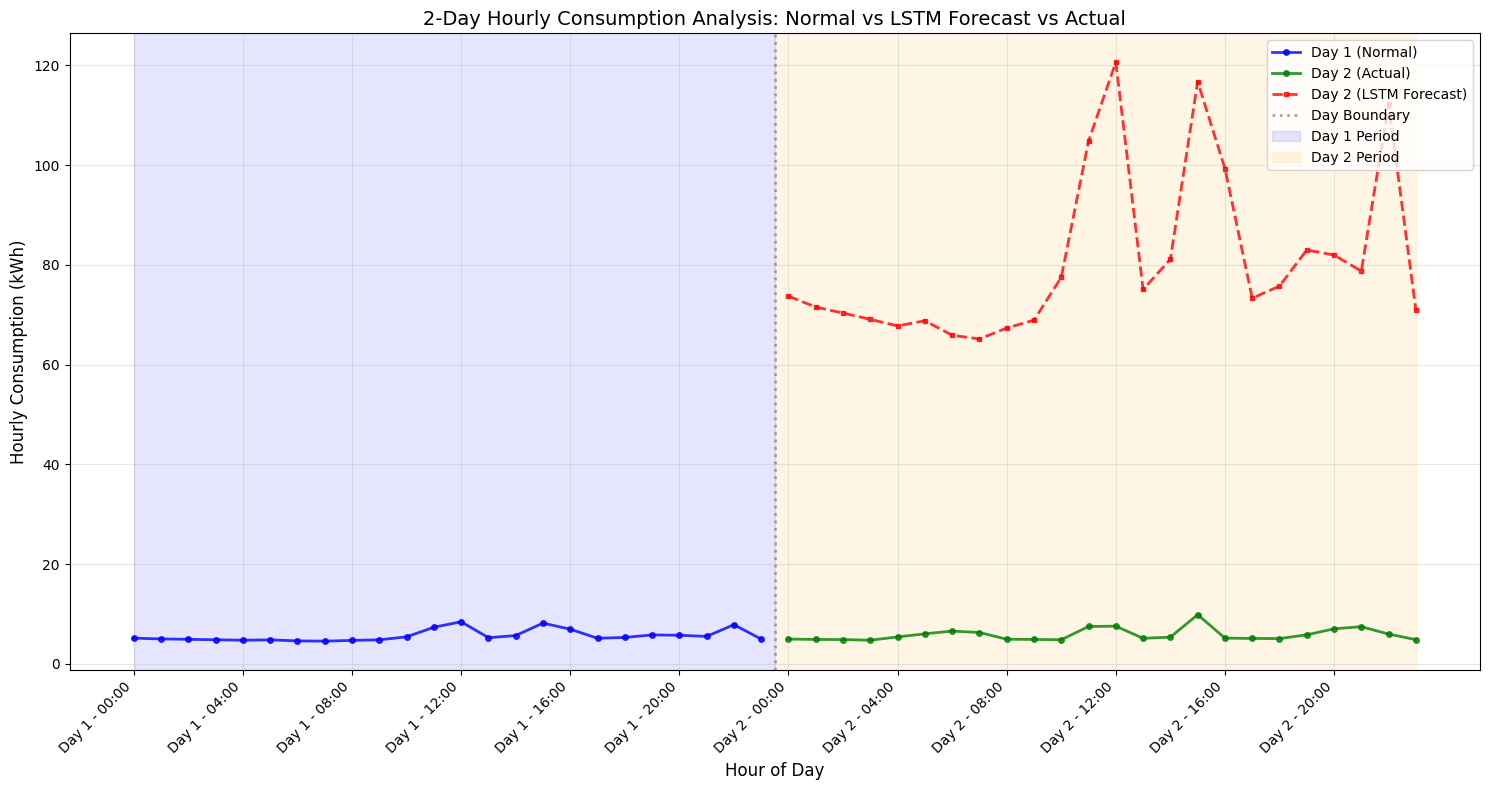


2-Day Hourly Consumption Analysis

Day 1 (Normal Operation):
  - Total consumption: 135.91 kWh
  - Average hourly: 5.663 kWh
  - Peak hour: 8.452 kWh
  - Min hour: 4.565 kWh

Day 2 (Actual vs LSTM Forecast):
  - Actual total: 140.53 kWh
  - LSTM Forecast total: 1939.32 kWh
  - Total error: 1798.79 kWh
  - Average hourly error: 74.950 kWh
  - RMSE: 76.574 kWh

LSTM Model Performance Metrics:
  - Mean Absolute Error (MAE): 74.9496 kWh
  - Mean Absolute Percentage Error (MAPE): 1299.72%
  - Root Mean Square Error (RMSE): 76.5738 kWh

Peak Consumption Analysis:
  - Day 1 peak at hour: 12:00
  - Day 2 actual peak at hour: 15:00

Hourly Forecast vs Actual (First 12 hours):
  Hour  0: Actual=4.9866 kWh, Forecast=73.7111 kWh, Error=1378.2%
  Hour  1: Actual=4.8963 kWh, Forecast=71.5247 kWh, Error=1360.8%
  Hour  2: Actual=4.8809 kWh, Forecast=70.3238 kWh, Error=1340.8%
  Hour  3: Actual=4.7528 kWh, Forecast=69.0687 kWh, Error=1353.2%
  Hour  4: Actual=5.4132 kWh, Forecast=67.7572 kWh, Error=1

In [115]:
# Create hourly consumption data for 2-day detailed analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert original data to hourly resolution
df_original = pd.read_csv('../../Data/data_preprocessed/predicition_data/fridge_data_for_prediction.csv', engine='python', skipfooter=3)
df_original['datetime'] = pd.to_datetime(df_original['timestamp'], unit='s')
df_original.set_index('datetime', inplace=True)

# Resample to hourly consumption (kWh)
hourly_df = df_original.resample('1H').sum(numeric_only=True)
hourly_df['value'] = hourly_df['value'] / 1000  # Convert from Wh to kWh
hourly_df = hourly_df.reset_index()

# Get the last 48 hours (2 days) of data
last_48_hours = hourly_df.iloc[-48:].copy()

# Split into Day 1 (first 24 hours) and Day 2 (last 24 hours)
day1_hours = last_48_hours.iloc[:24].copy()
day2_hours = last_48_hours.iloc[24:].copy()

# Generate LSTM predictions for Day 2 hourly data
# Method 1: Use daily prediction and distribute hourly based on Day 1 pattern
if len(predictions) > 0:
    # Get the latest daily prediction from LSTM
    latest_daily_pred = predictions.iloc[-1] if hasattr(predictions, 'iloc') else predictions[-1]
    
    # Calculate Day 1 hourly pattern (normalized)
    day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
    
    # Apply the pattern to the predicted daily consumption
    day2_forecast = latest_daily_pred * day1_hourly_pattern
else:
    # Fallback if no predictions available
    day2_forecast = day2_hours['value'].values * (1 + np.random.normal(0, 0.1, 24))

# Alternative Method 2: Multi-step ahead prediction using the trained model
# Uncomment this section if you want to use multi-step prediction instead
"""
# Prepare the last sequence from daily data for multi-step prediction
last_sequence = df[-lookback:].reshape(1, 1, lookback)
last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1)).reshape(1, 1, lookback)

# Generate 24 hourly predictions (assuming model can be adapted for hourly)
daily_pred_scaled = model.predict(last_sequence_scaled)
daily_pred = scaler.inverse_transform(daily_pred_scaled)[0][0]

# Distribute the daily prediction across 24 hours using Day 1 pattern
day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
day2_forecast = daily_pred * day1_hourly_pattern
"""

# Create the plot
plt.figure(figsize=(15, 8))

# Create hour labels for x-axis
day1_hours_labels = [f"Day 1 - {i:02d}:00" for i in range(24)]
day2_hours_labels = [f"Day 2 - {i:02d}:00" for i in range(24)]
all_hours_labels = day1_hours_labels + day2_hours_labels

# X-axis positions
x_positions = list(range(48))

# Plot Day 1 (Normal consumption - no predictions)
plt.plot(x_positions[:24], day1_hours['value'], 
         'b-o', linewidth=2, markersize=4, label='Day 1 (Normal)', alpha=0.8)

# Plot Day 2 (Actual consumption)
plt.plot(x_positions[24:], day2_hours['value'], 
         'g-o', linewidth=2, markersize=4, label='Day 2 (Actual)', alpha=0.8)

# Plot Day 2 (LSTM Forecast consumption)
plt.plot(x_positions[24:], day2_forecast, 
         'r--s', linewidth=2, markersize=3, label='Day 2 (LSTM Forecast)', alpha=0.8)

# Add vertical line to separate days
plt.axvline(x=23.5, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Day Boundary')

# Add shaded regions for each day
plt.axvspan(0, 23.5, alpha=0.1, color='blue', label='Day 1 Period')
plt.axvspan(23.5, 47, alpha=0.1, color='orange', label='Day 2 Period')

# Formatting
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Hourly Consumption (kWh)', fontsize=12)
plt.title('2-Day Hourly Consumption Analysis: Normal vs LSTM Forecast vs Actual', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show every 4 hours
tick_positions = list(range(0, 48, 4))
tick_labels = [all_hours_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed hourly analysis
print(f"\n{'='*60}")
print(f"2-Day Hourly Consumption Analysis")
print(f"{'='*60}")

print(f"\nDay 1 (Normal Operation):")
print(f"  - Total consumption: {day1_hours['value'].sum():.2f} kWh")
print(f"  - Average hourly: {day1_hours['value'].mean():.3f} kWh")
print(f"  - Peak hour: {day1_hours['value'].max():.3f} kWh")
print(f"  - Min hour: {day1_hours['value'].min():.3f} kWh")

print(f"\nDay 2 (Actual vs LSTM Forecast):")
print(f"  - Actual total: {day2_hours['value'].sum():.2f} kWh")
print(f"  - LSTM Forecast total: {day2_forecast.sum():.2f} kWh")
print(f"  - Total error: {abs(day2_hours['value'].sum() - day2_forecast.sum()):.2f} kWh")
print(f"  - Average hourly error: {np.mean(np.abs(day2_hours['value'] - day2_forecast)):.3f} kWh")
print(f"  - RMSE: {np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2)):.3f} kWh")

# Calculate accuracy metrics
mae = np.mean(np.abs(day2_hours['value'] - day2_forecast))
mape = np.mean(np.abs((day2_hours['value'] - day2_forecast) / day2_hours['value'])) * 100
rmse = np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2))

print(f"\nLSTM Model Performance Metrics:")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kWh")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  - Root Mean Square Error (RMSE): {rmse:.4f} kWh")

# Show peak consumption hours
day1_peak_hour = day1_hours['value'].idxmax()
day2_actual_peak_hour = day2_hours['value'].idxmax()

print(f"\nPeak Consumption Analysis:")
print(f"  - Day 1 peak at hour: {day1_hours.loc[day1_peak_hour, 'datetime'].strftime('%H:%M')}")
print(f"  - Day 2 actual peak at hour: {day2_hours.loc[day2_actual_peak_hour, 'datetime'].strftime('%H:%M')}")

# Additional analysis: hourly comparison
print(f"\nHourly Forecast vs Actual (First 12 hours):")
for i in range(12):
    actual_val = day2_hours['value'].iloc[i]
    forecast_val = day2_forecast[i]
    error_pct = abs(actual_val - forecast_val) / actual_val * 100
    print(f"  Hour {i:2d}: Actual={actual_val:.4f} kWh, Forecast={forecast_val:.4f} kWh, Error={error_pct:.1f}%")

## Fridge Consumption Forecast 


In [26]:
df = pd.read_csv('../../Data/data_preprocessed/predicition_data/fridge_data_for_prediction.csv', engine='python', skipfooter=3)
df

,measurement,appliance,value,timestamp
0,Electricity,fridge,73.769,1661990400
1,Electricity,fridge,73.164,1661990430
2,Electricity,fridge,73.134,1661990460
3,Electricity,fridge,73.115,1661990490
4,Electricity,fridge,73.391,1661990520
...,...,...,...,...
1026922,Electricity,fridge,82.227,1693526160
1026923,Electricity,fridge,81.909,1693526190
1026924,Electricity,fridge,82.004,1693526220
1026925,Electricity,fridge,82.292,1693526250


(array([19236., 19297., 19358., 19417., 19478., 19539., 19601.]),
 [Text(19236.0, 0, '2022-09-01 00:00:00'),
  Text(19297.0, 0, '2022-11-01 00:00:00'),
  Text(19358.0, 0, '2023-01-01 00:00:00'),
  Text(19417.0, 0, '2023-03-01 00:00:00'),
  Text(19478.0, 0, '2023-05-01 00:00:00'),
  Text(19539.0, 0, '2023-07-01 00:00:00'),
  Text(19601.0, 0, '2023-09-01 00:00:00')])

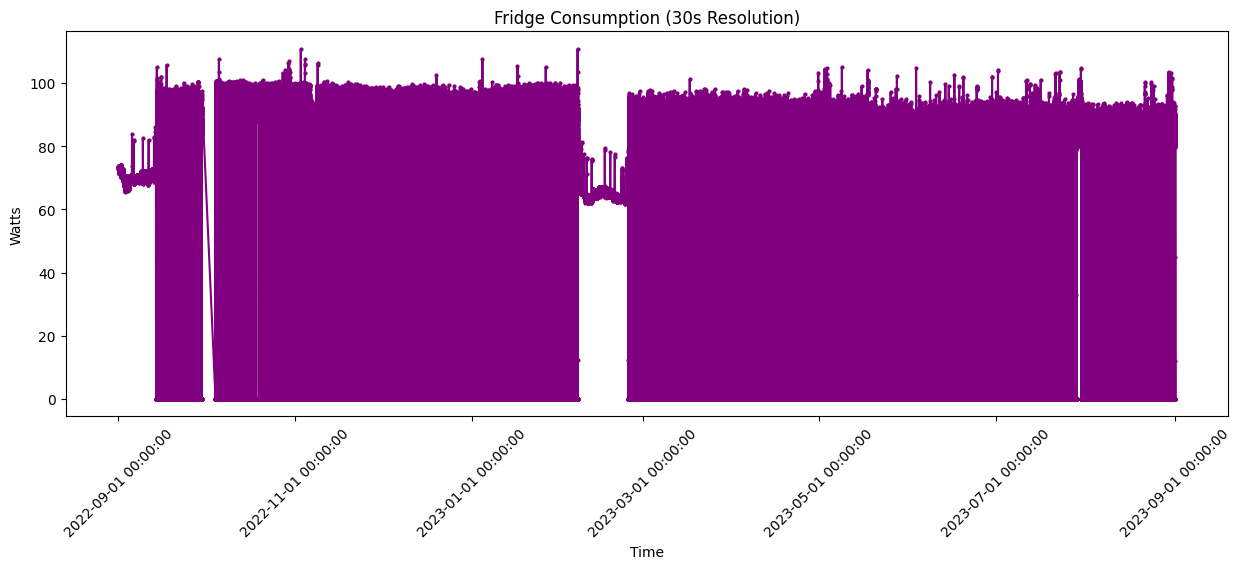

In [6]:
import matplotlib.dates as mdates
# Convert timestamp to datetime (assuming it's in seconds since epoch)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# Plot the 30-second resolution data
plt.figure(figsize=(15, 5))
plt.plot(df['timestamp'], df['value'], linestyle='-', marker='o', markersize=2, color='purple')
plt.title('Fridge Consumption (30s Resolution)')
plt.xlabel('Time')
plt.ylabel('Watts')
# Format x-axis to show date and time
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)


C:\Users\Ghada\AppData\Local\Temp\ipykernel_22196\4147828058.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mask = (df['datetime'] >= pd.to_datetime(start_time, unit='s')) & (df['datetime'] <= pd.to_datetime(end_time, unit='s'))
C:\Users\Ghada\AppData\Local\Temp\ipykernel_22196\4147828058.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  plt.title(f'Fridge Consumption from {pd.to_datetime(start_time, unit="s")} to {pd.to_datetime(end_time, unit="s")}')


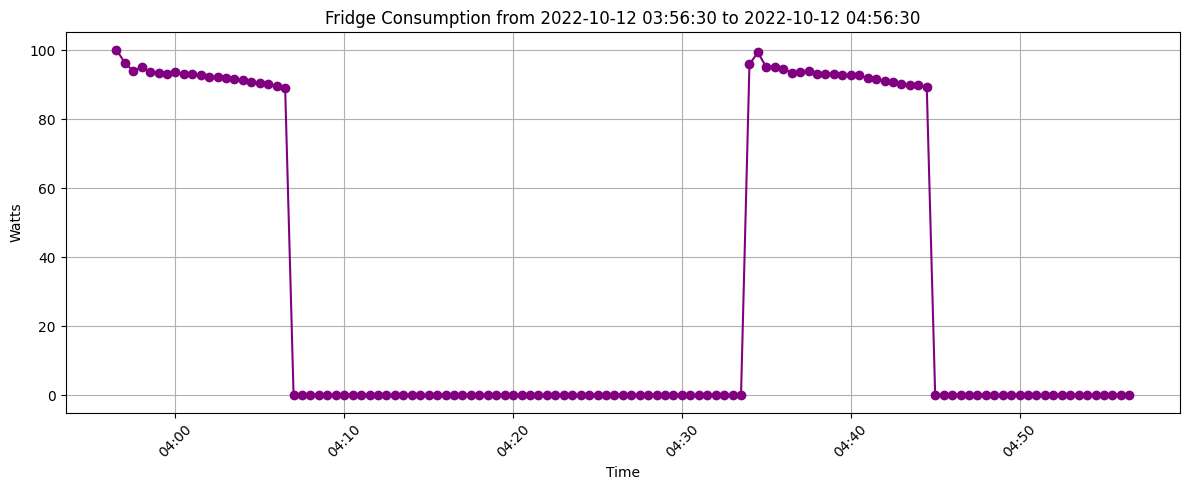

In [13]:
import matplotlib.dates as mdates

# Define your start and end timestamps (in 'YYYY-MM-DD HH:MM:SS' format)
start_time = '1665546990'
end_time = '1665550590'

# Ensure 'datetime' column exists and is in datetime format
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Filter the DataFrame between the two timestamps
mask = (df['datetime'] >= pd.to_datetime(start_time, unit='s')) & (df['datetime'] <= pd.to_datetime(end_time, unit='s'))
df_window = df.loc[mask]

# Plot the values in the selected window
plt.figure(figsize=(12, 5))
plt.plot(df_window['datetime'], df_window['value'], marker='o', color='purple')
plt.title(f'Fridge Consumption from {pd.to_datetime(start_time, unit="s")} to {pd.to_datetime(end_time, unit="s")}')
plt.xlabel('Time')
plt.ylabel('Watts')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Ghada\AppData\Local\Temp\ipykernel_22196\619133123.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  mask = (df['datetime'] >= pd.to_datetime(start_time, unit='s')) & (df['datetime'] <= pd.to_datetime(end_time, unit='s'))
C:\Users\Ghada\AppData\Local\Temp\ipykernel_22196\619133123.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  plt.title(f'Fridge Consumption from {pd.to_datetime(start_time, unit="s")} to {pd.to_datetime(end_time, unit="s")}')


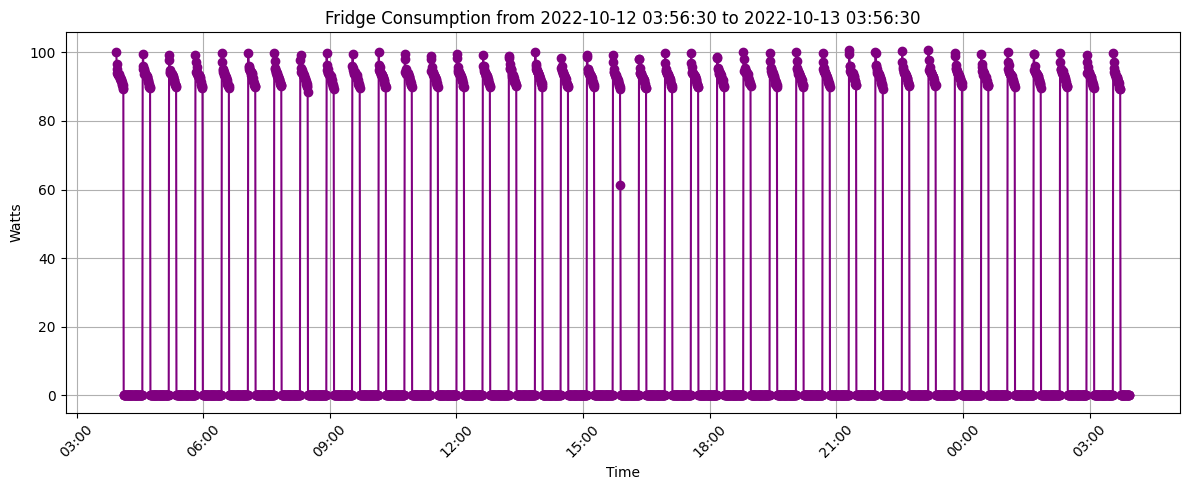

In [8]:
import matplotlib.dates as mdates

# Define your start and end timestamps (in 'YYYY-MM-DD HH:MM:SS' format)
start_time = '1665546990'
end_time = '1665633390'

# Ensure 'datetime' column exists and is in datetime format
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Filter the DataFrame between the two timestamps
mask = (df['datetime'] >= pd.to_datetime(start_time, unit='s')) & (df['datetime'] <= pd.to_datetime(end_time, unit='s'))
df_window = df.loc[mask]

# Plot the values in the selected window
plt.figure(figsize=(12, 5))
plt.plot(df_window['datetime'], df_window['value'], marker='o', color='purple')
plt.title(f'Fridge Consumption from {pd.to_datetime(start_time, unit="s")} to {pd.to_datetime(end_time, unit="s")}')
plt.xlabel('Time')
plt.ylabel('Watts')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

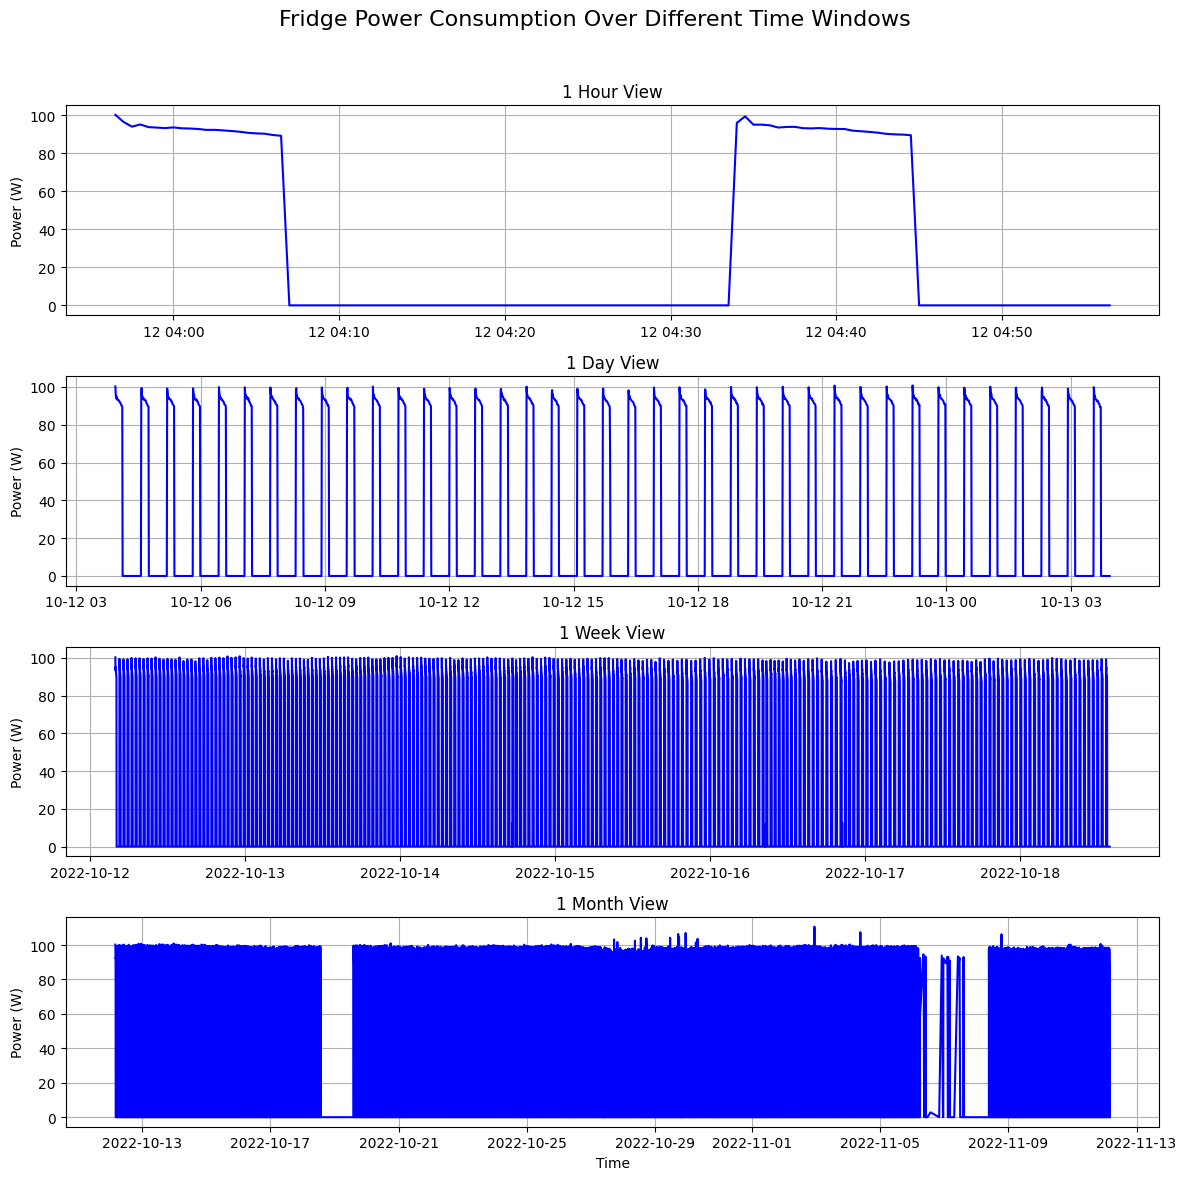

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert timestamp column to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('datetime', inplace=True)

# Start time
start_time = pd.to_datetime(1665546990, unit='s')

# Time ranges
ranges = {
    '1 Hour': start_time + pd.Timedelta(hours=1),
    '1 Day': start_time + pd.Timedelta(days=1),
    '1 Week': start_time + pd.Timedelta(weeks=1),
    '1 Month': start_time + pd.DateOffset(months=1),
}

# Plot setup
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=False)
fig.suptitle('Fridge Power Consumption Over Different Time Windows', fontsize=16)

# Generate subplots
for ax, (label, end_time) in zip(axes, ranges.items()):
    df_window = df.loc[start_time:end_time]
    ax.plot(df_window.index, df_window['value'], color='blue')
    ax.set_title(f"{label} View")
    ax.set_ylabel("Power (W)")
    ax.grid(True)

axes[-1].set_xlabel("Time")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [28]:
# Convert 'timestamp' to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Set datetime as index for resampling
df.set_index('datetime', inplace=True)

# Resample to daily sum of 'value' in kilowatts (kWh)
daily_df = df.resample('1D').sum(numeric_only=True)
daily_df['value'] = daily_df['value'] / 1000  # Convert from Wh to kWh


# Reset index to turn datetime back into a column
daily_df = daily_df.reset_index()

# Add iteration column
daily_df['iteration'] = range(len(daily_df))

# Reorder columns
daily_df = daily_df[['iteration', 'datetime', 'value']]

# Final result
print(daily_df)

     iteration   datetime       value
0            0 2022-09-01  208.014487
1            1 2022-09-02  203.521153
2            2 2022-09-03  195.295954
3            3 2022-09-04  195.896129
4            4 2022-09-05  201.047171
..         ...        ...         ...
360        360 2023-08-27  164.724659
361        361 2023-08-28  155.645924
362        362 2023-08-29  159.077031
363        363 2023-08-30  135.911309
364        364 2023-08-31  140.527821

[365 rows x 3 columns]


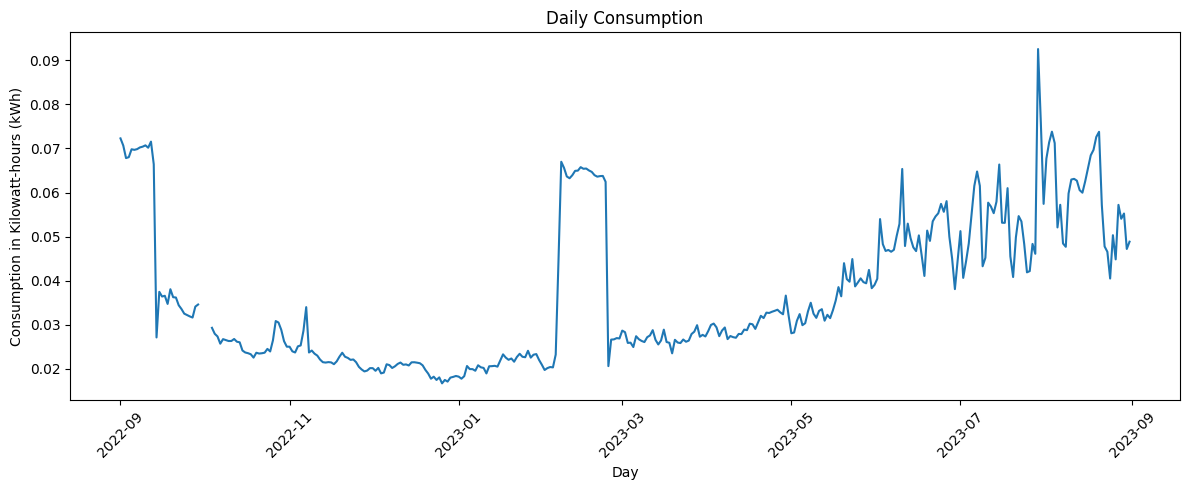

In [12]:
# Plot only the 'value' column against the 'datetime'
plt.figure(figsize=(12, 5))
plt.plot(daily_df['datetime'], daily_df['value']/ 1000)

# Format the x-axis ticks to show dates
plt.xlabel('Day')
plt.ylabel('Consumption in Kilowatt-hours (kWh)')
plt.title("Daily Consumption")

# Rotate and format date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [29]:
tseries= daily_df.drop('datetime', axis=1)
tseries = tseries.drop('iteration', axis=1)
df=pd.DataFrame(tseries)
df

,value
0,208.014487
1,203.521153
2,195.295954
3,195.896129
4,201.047171
...,...
360,164.724659
361,155.645924
362,159.077031
363,135.911309


In [30]:
df=np.array(df)
df

array([[208.014487  ],
       [203.521153  ],
       [195.2959545 ],
       [195.896129  ],
       [201.0471715 ],
       [200.681182  ],
       [201.14018893],
       [202.03594492],
       [202.75217783],
       [203.6121155 ],
       [202.057891  ],
       [206.048036  ],
       [191.2716565 ],
       [ 78.098872  ],
       [107.912482  ],
       [104.8429025 ],
       [105.31610333],
       [100.009932  ],
       [109.607848  ],
       [104.3925215 ],
       [104.188765  ],
       [ 99.15449   ],
       [ 96.6867825 ],
       [ 93.65131   ],
       [ 92.7688745 ],
       [ 91.851849  ],
       [ 91.10103875],
       [ 98.241268  ],
       [ 74.091745  ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [  0.        ],
       [ 41.992133  ],
       [ 80.5048125 ],
       [ 78.747957  ],
       [ 74.02659   ],
       [ 76.9934    ],
       [ 76.381266  ],
       [ 75.740834  ],
       [ 75.7866075 ],
       [ 77.090419  ],
       [ 75.3107    ],
       [ 74

In [31]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

In [32]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
train


array([[1.        ],
       [0.97839894],
       [0.93885747],
       [0.94174272],
       [0.96650562],
       [0.96474618],
       [0.96695279],
       [0.97125901],
       [0.9747022 ],
       [0.97883623],
       [0.97136451],
       [0.99054657],
       [0.91951123],
       [0.3754492 ],
       [0.51877388],
       [0.50401731],
       [0.50629216],
       [0.48078349],
       [0.52692411],
       [0.50185217],
       [0.50087264],
       [0.47667108],
       [0.46480793],
       [0.45021533],
       [0.44597314],
       [0.44156467],
       [0.43795526],
       [0.47228089],
       [0.3561855 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.20187119],
       [0.38701541],
       [0.37856958],
       [0.35587228],
       [0.3701348 ],
       [0.36719205],
       [0.36411326],
       [0.36433331],
       [0.3706012 ],
       [0.36204546],
       [0.36017385],
       [0.33443723],
       [0.32820697],
       [0.3260117 ],
       [0.186

In [34]:
test = scaler.fit_transform(test)
test

array([[0.20081807],
       [0.2823779 ],
       [0.30255686],
       [0.31592072],
       [0.35504224],
       [0.32204984],
       [0.36642231],
       [0.21850992],
       [0.127085  ],
       [0.        ],
       [0.12216837],
       [0.24159432],
       [0.04688196],
       [0.11410704],
       [0.18953881],
       [0.3072768 ],
       [0.42964829],
       [0.48995692],
       [0.42991776],
       [0.09513058],
       [0.13061084],
       [0.3601381 ],
       [0.34374886],
       [0.31634816],
       [0.3643374 ],
       [0.51900599],
       [0.27653892],
       [0.27609863],
       [0.42054568],
       [0.13668296],
       [0.05040456],
       [0.21561865],
       [0.30407884],
       [0.28175794],
       [0.18814709],
       [0.06991556],
       [0.07510588],
       [0.18841355],
       [0.14722129],
       [1.        ],
       [0.69323929],
       [0.35509112],
       [0.54357104],
       [0.61149581],
       [0.65576857],
       [0.60822873],
       [0.25698935],
       [0.351

In [35]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_test, Y_test = create_dataset(test, lookback)

In [ ]:
# Lookback period
lookback = 15
X_train, Y_train = create_dataset(train, lookback)
X_test, Y_test = create_dataset(test, lookback)

In [36]:
print("X training=",X_train)
print("Y training=",Y_train)

X training= [[1.         0.97839894 0.93885747 0.94174272 0.96650562]
 [0.97839894 0.93885747 0.94174272 0.96650562 0.96474618]
 [0.93885747 0.94174272 0.96650562 0.96474618 0.96695279]
 ...
 [0.66262124 0.73292988 0.6873841  0.65843579 0.64666285]
 [0.73292988 0.6873841  0.65843579 0.64666285 0.6959961 ]
 [0.6873841  0.65843579 0.64666285 0.6959961  0.63411026]]
Y training= [0.96474618 0.96695279 0.97125901 0.9747022  0.97883623 0.97136451
 0.99054657 0.91951123 0.3754492  0.51877388 0.50401731 0.50629216
 0.48078349 0.52692411 0.50185217 0.50087264 0.47667108 0.46480793
 0.45021533 0.44597314 0.44156467 0.43795526 0.47228089 0.3561855
 0.         0.         0.         0.         0.20187119 0.38701541
 0.37856958 0.35587228 0.3701348  0.36719205 0.36411326 0.36433331
 0.3706012  0.36204546 0.36017385 0.33443723 0.32820697 0.3260117
 0.18697079 0.13190013 0.32741958 0.32488779 0.32580519 0.32757622
 0.33947287 0.33146761 0.36653061 0.4269382  0.4223142  0.39941816
 0.36375001 0.3464849

In [37]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [38]:
X_train.shape

(286, 1, 5)

In [39]:
X_train.shape[0]

286

In [40]:
X_train.shape[1]

1

Epoch 1/100
15/15 - 1s - loss: 0.1811 - val_loss: 0.1945 - 1s/epoch - 72ms/step
Epoch 2/100
15/15 - 0s - loss: 0.0866 - val_loss: 0.0839 - 94ms/epoch - 6ms/step
Epoch 3/100
15/15 - 0s - loss: 0.0328 - val_loss: 0.0231 - 94ms/epoch - 6ms/step
Epoch 4/100
15/15 - 0s - loss: 0.0154 - val_loss: 0.0056 - 96ms/epoch - 6ms/step
Epoch 5/100
15/15 - 0s - loss: 0.0126 - val_loss: 0.0047 - 96ms/epoch - 6ms/step
Epoch 6/100
15/15 - 0s - loss: 0.0124 - val_loss: 0.0056 - 95ms/epoch - 6ms/step
Epoch 7/100
15/15 - 0s - loss: 0.0119 - val_loss: 0.0067 - 96ms/epoch - 6ms/step
Epoch 8/100
15/15 - 0s - loss: 0.0118 - val_loss: 0.0073 - 95ms/epoch - 6ms/step
Epoch 9/100
15/15 - 0s - loss: 0.0114 - val_loss: 0.0064 - 92ms/epoch - 6ms/step
Epoch 10/100
15/15 - 0s - loss: 0.0111 - val_loss: 0.0055 - 93ms/epoch - 6ms/step
Epoch 11/100
15/15 - 0s - loss: 0.0110 - val_loss: 0.0045 - 96ms/epoch - 6ms/step
Epoch 12/100
15/15 - 0s - loss: 0.0107 - val_loss: 0.0058 - 95ms/epoch - 6ms/step
Epoch 13/100
15/15 - 0s - 

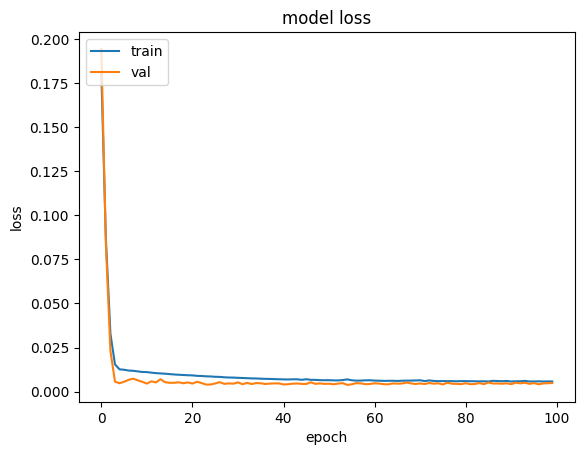

In [41]:
# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(64, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=100, batch_size=16, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
# Generate predictions
trainpred = model.predict(X_train)
testpred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [43]:
trainpred

array([[0.91722083],
       [0.9210856 ],
       [0.92465997],
       [0.927425  ],
       [0.9310504 ],
       [0.9358258 ],
       [0.9284569 ],
       [0.94687605],
       [0.87807   ],
       [0.36803335],
       [0.45602256],
       [0.43474695],
       [0.48087028],
       [0.45488456],
       [0.4916343 ],
       [0.47278833],
       [0.47424737],
       [0.44977027],
       [0.43978044],
       [0.42609438],
       [0.42287374],
       [0.41931716],
       [0.41694874],
       [0.44459635],
       [0.353754  ],
       [0.08255292],
       [0.06475617],
       [0.06417268],
       [0.09169876],
       [0.2265625 ],
       [0.36843464],
       [0.38540754],
       [0.36421663],
       [0.36016762],
       [0.35735834],
       [0.3569588 ],
       [0.35599002],
       [0.3609217 ],
       [0.35490257],
       [0.35314837],
       [0.3323395 ],
       [0.32639349],
       [0.3234044 ],
       [0.22061256],
       [0.17489783],
       [0.30889592],
       [0.3254189 ],
       [0.339

In [44]:
testpred

array([[0.34953   ],
       [0.32567227],
       [0.3585058 ],
       [0.24461375],
       [0.17445078],
       [0.07512599],
       [0.16074286],
       [0.2516709 ],
       [0.13794595],
       [0.17085472],
       [0.20935874],
       [0.31270337],
       [0.4109326 ],
       [0.46837747],
       [0.42391837],
       [0.15688278],
       [0.16005507],
       [0.32155997],
       [0.34676468],
       [0.33528745],
       [0.35355723],
       [0.47777215],
       [0.30108377],
       [0.29026887],
       [0.38001734],
       [0.18898903],
       [0.1232599 ],
       [0.21463989],
       [0.302562  ],
       [0.30567563],
       [0.22942679],
       [0.13294089],
       [0.12954953],
       [0.21044727],
       [0.1964675 ],
       [0.8535385 ],
       [0.6700125 ],
       [0.4144604 ],
       [0.47160593],
       [0.54307294],
       [0.62107027],
       [0.5776701 ],
       [0.27722383],
       [0.32711297],
       [0.1957978 ],
       [0.20987578],
       [0.36330932],
       [0.432

In [45]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])
predictions = testpred

In [46]:
Y_train.shape
Y_test.shape
X_train.shape
X_test.shape
Y_train
Y_test
X_train
X_test

array([[[0.20081807, 0.2823779 , 0.30255686, 0.31592072, 0.35504224]],

       [[0.2823779 , 0.30255686, 0.31592072, 0.35504224, 0.32204984]],

       [[0.30255686, 0.31592072, 0.35504224, 0.32204984, 0.36642231]],

       [[0.31592072, 0.35504224, 0.32204984, 0.36642231, 0.21850992]],

       [[0.35504224, 0.32204984, 0.36642231, 0.21850992, 0.127085  ]],

       [[0.32204984, 0.36642231, 0.21850992, 0.127085  , 0.        ]],

       [[0.36642231, 0.21850992, 0.127085  , 0.        , 0.12216837]],

       [[0.21850992, 0.127085  , 0.        , 0.12216837, 0.24159432]],

       [[0.127085  , 0.        , 0.12216837, 0.24159432, 0.04688196]],

       [[0.        , 0.12216837, 0.24159432, 0.04688196, 0.11410704]],

       [[0.12216837, 0.24159432, 0.04688196, 0.11410704, 0.18953881]],

       [[0.24159432, 0.04688196, 0.11410704, 0.18953881, 0.3072768 ]],

       [[0.04688196, 0.11410704, 0.18953881, 0.3072768 , 0.42964829]],

       [[0.11410704, 0.18953881, 0.3072768 , 0.42964829, 0.48995

In [47]:
# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_test[0], testpred[:,0]))
print('Test Score: %.2f RMSE' % (valScore))

Train Score: 11.56 RMSE
Test Score: 25.45 RMSE


In [48]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [49]:
# Test predictions
testpredPlot = np.empty_like(df)
testpredPlot[:, :] = np.nan
testpredPlot[len(trainpred)+(lookback*2)+1:len(df)-1, :] = testpred

In [50]:
Y_test=Y_test.reshape(-1)
Y_test.shape
Y_test=pd.Series(Y_test)

In [51]:
Y_test

0     160.191599
1     167.151946
2     143.950139
3     129.609060
4     109.674277
         ...    
62    129.118505
63    164.724659
64    155.645924
65    159.077031
66    135.911309
Length: 67, dtype: float64

In [52]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [53]:
predictions

0     164.502197
1     160.759811
2     165.910141
3     148.044830
4     137.038940
         ...    
62    147.010086
63    137.136185
64    163.946976
65    156.913300
66    161.519348
Length: 67, dtype: float32

In [54]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [55]:
mda(Y_test, predictions)

0.9701492537313433

In [56]:
np.mean(Y_test)

160.6301763942786

C:\Users\Ghada\AppData\Local\Temp\ipykernel_28396\682194490.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_df = df_original.resample('1H').sum(numeric_only=True)


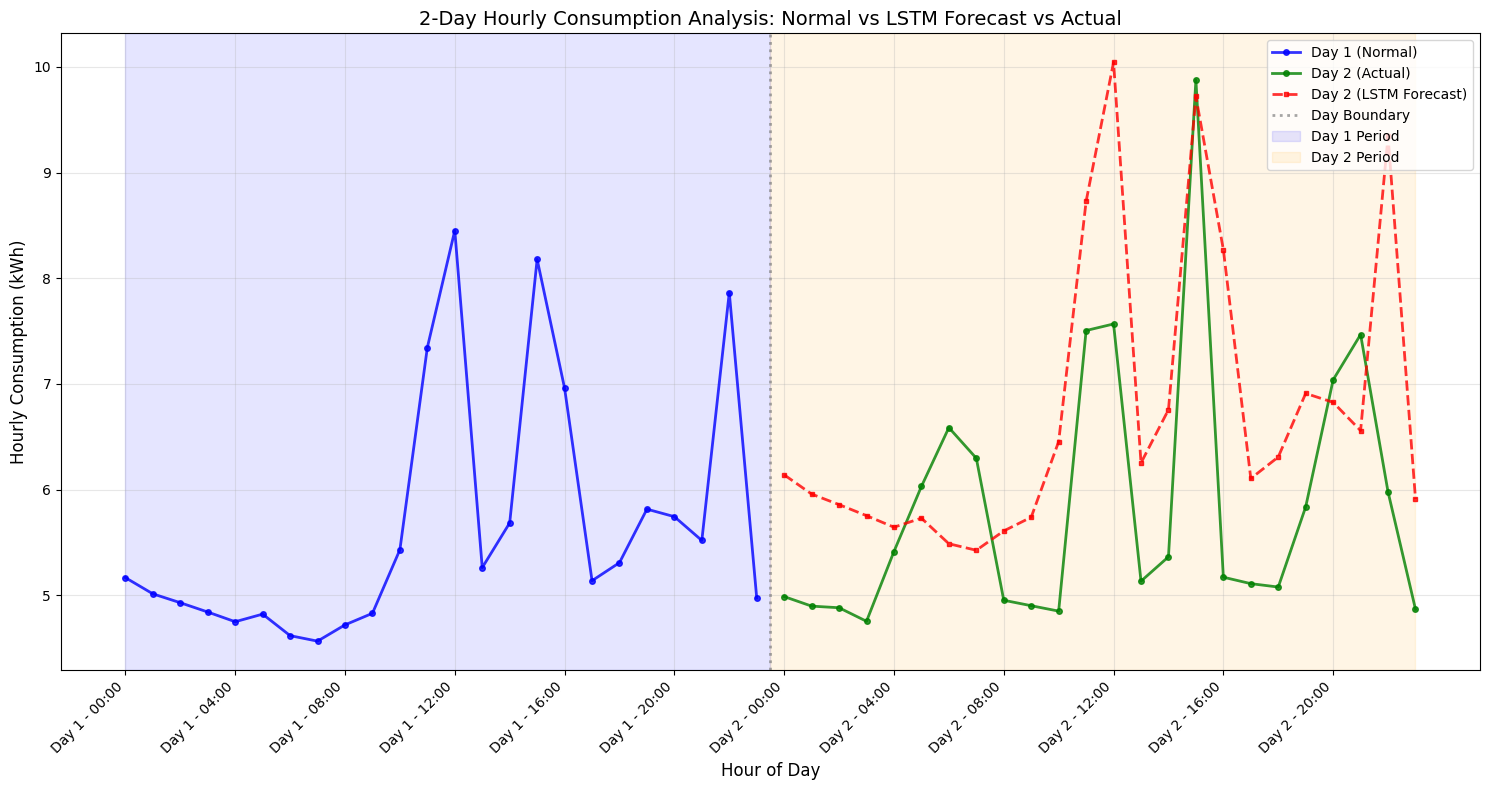


2-Day Hourly Consumption Analysis

Day 1 (Normal Operation):
  - Total consumption: 135.91 kWh
  - Average hourly: 5.663 kWh
  - Peak hour: 8.452 kWh
  - Min hour: 4.565 kWh

Day 2 (Actual vs LSTM Forecast):
  - Actual total: 140.53 kWh
  - LSTM Forecast total: 161.52 kWh
  - Total error: 20.99 kWh
  - Average hourly error: 1.170 kWh
  - RMSE: 1.409 kWh

LSTM Model Performance Metrics:
  - Mean Absolute Error (MAE): 1.1705 kWh
  - Mean Absolute Percentage Error (MAPE): 20.94%
  - Root Mean Square Error (RMSE): 1.4091 kWh

Peak Consumption Analysis:
  - Day 1 peak at hour: 12:00
  - Day 2 actual peak at hour: 15:00

Hourly Forecast vs Actual (First 12 hours):
  Hour  0: Actual=4.9866 kWh, Forecast=6.1392 kWh, Error=23.1%
  Hour  1: Actual=4.8963 kWh, Forecast=5.9571 kWh, Error=21.7%
  Hour  2: Actual=4.8809 kWh, Forecast=5.8570 kWh, Error=20.0%
  Hour  3: Actual=4.7528 kWh, Forecast=5.7525 kWh, Error=21.0%
  Hour  4: Actual=5.4132 kWh, Forecast=5.6433 kWh, Error=4.3%
  Hour  5: Actual=

In [58]:
# Create hourly consumption data for 2-day detailed analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert original data to hourly resolution
df_original = pd.read_csv('../../Data/data_preprocessed/predicition_data/fridge_data_for_prediction.csv', engine='python', skipfooter=3)
df_original['datetime'] = pd.to_datetime(df_original['timestamp'], unit='s')
df_original.set_index('datetime', inplace=True)

# Resample to hourly consumption (kWh)
hourly_df = df_original.resample('1H').sum(numeric_only=True)
hourly_df['value'] = hourly_df['value'] / 1000  # Convert from Wh to kWh
hourly_df = hourly_df.reset_index()

# Get the last 48 hours (2 days) of data
last_48_hours = hourly_df.iloc[-48:].copy()

# Split into Day 1 (first 24 hours) and Day 2 (last 24 hours)
day1_hours = last_48_hours.iloc[:24].copy()
day2_hours = last_48_hours.iloc[24:].copy()

# Generate LSTM predictions for Day 2 hourly data
# Method 1: Use daily prediction and distribute hourly based on Day 1 pattern
if len(predictions) > 0:
    # Get the latest daily prediction from LSTM
    latest_daily_pred = predictions.iloc[-1] if hasattr(predictions, 'iloc') else predictions[-1]
    
    # Calculate Day 1 hourly pattern (normalized)
    day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
    
    # Apply the pattern to the predicted daily consumption
    day2_forecast = latest_daily_pred * day1_hourly_pattern
else:
    # Fallback if no predictions available
    day2_forecast = day2_hours['value'].values * (1 + np.random.normal(0, 0.1, 24))

# Alternative Method 2: Multi-step ahead prediction using the trained model
# Uncomment this section if you want to use multi-step prediction instead
"""
# Prepare the last sequence from daily data for multi-step prediction
last_sequence = df[-lookback:].reshape(1, 1, lookback)
last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1)).reshape(1, 1, lookback)

# Generate 24 hourly predictions (assuming model can be adapted for hourly)
daily_pred_scaled = model.predict(last_sequence_scaled)
daily_pred = scaler.inverse_transform(daily_pred_scaled)[0][0]

# Distribute the daily prediction across 24 hours using Day 1 pattern
day1_hourly_pattern = day1_hours['value'].values / day1_hours['value'].sum()
day2_forecast = daily_pred * day1_hourly_pattern
"""

# Create the plot
plt.figure(figsize=(15, 8))

# Create hour labels for x-axis
day1_hours_labels = [f"Day 1 - {i:02d}:00" for i in range(24)]
day2_hours_labels = [f"Day 2 - {i:02d}:00" for i in range(24)]
all_hours_labels = day1_hours_labels + day2_hours_labels

# X-axis positions
x_positions = list(range(48))

# Plot Day 1 (Normal consumption - no predictions)
plt.plot(x_positions[:24], day1_hours['value'], 
         'b-o', linewidth=2, markersize=4, label='Day 1 (Normal)', alpha=0.8)

# Plot Day 2 (Actual consumption)
plt.plot(x_positions[24:], day2_hours['value'], 
         'g-o', linewidth=2, markersize=4, label='Day 2 (Actual)', alpha=0.8)

# Plot Day 2 (LSTM Forecast consumption)
plt.plot(x_positions[24:], day2_forecast, 
         'r--s', linewidth=2, markersize=3, label='Day 2 (LSTM Forecast)', alpha=0.8)

# Add vertical line to separate days
plt.axvline(x=23.5, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Day Boundary')

# Add shaded regions for each day
plt.axvspan(0, 23.5, alpha=0.1, color='blue', label='Day 1 Period')
plt.axvspan(23.5, 47, alpha=0.1, color='orange', label='Day 2 Period')

# Formatting
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Hourly Consumption (kWh)', fontsize=12)
plt.title('2-Day Hourly Consumption Analysis: Normal vs LSTM Forecast vs Actual', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show every 4 hours
tick_positions = list(range(0, 48, 4))
tick_labels = [all_hours_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed hourly analysis
print(f"\n{'='*60}")
print(f"2-Day Hourly Consumption Analysis")
print(f"{'='*60}")

print(f"\nDay 1 (Normal Operation):")
print(f"  - Total consumption: {day1_hours['value'].sum():.2f} kWh")
print(f"  - Average hourly: {day1_hours['value'].mean():.3f} kWh")
print(f"  - Peak hour: {day1_hours['value'].max():.3f} kWh")
print(f"  - Min hour: {day1_hours['value'].min():.3f} kWh")

print(f"\nDay 2 (Actual vs LSTM Forecast):")
print(f"  - Actual total: {day2_hours['value'].sum():.2f} kWh")
print(f"  - LSTM Forecast total: {day2_forecast.sum():.2f} kWh")
print(f"  - Total error: {abs(day2_hours['value'].sum() - day2_forecast.sum()):.2f} kWh")
print(f"  - Average hourly error: {np.mean(np.abs(day2_hours['value'] - day2_forecast)):.3f} kWh")
print(f"  - RMSE: {np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2)):.3f} kWh")

# Calculate accuracy metrics
mae = np.mean(np.abs(day2_hours['value'] - day2_forecast))
mape = np.mean(np.abs((day2_hours['value'] - day2_forecast) / day2_hours['value'])) * 100
rmse = np.sqrt(np.mean((day2_hours['value'] - day2_forecast)**2))

print(f"\nLSTM Model Performance Metrics:")
print(f"  - Mean Absolute Error (MAE): {mae:.4f} kWh")
print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"  - Root Mean Square Error (RMSE): {rmse:.4f} kWh")

# Show peak consumption hours
day1_peak_hour = day1_hours['value'].idxmax()
day2_actual_peak_hour = day2_hours['value'].idxmax()

print(f"\nPeak Consumption Analysis:")
print(f"  - Day 1 peak at hour: {day1_hours.loc[day1_peak_hour, 'datetime'].strftime('%H:%M')}")
print(f"  - Day 2 actual peak at hour: {day2_hours.loc[day2_actual_peak_hour, 'datetime'].strftime('%H:%M')}")

# Additional analysis: hourly comparison
print(f"\nHourly Forecast vs Actual (First 12 hours):")
for i in range(12):
    actual_val = day2_hours['value'].iloc[i]
    forecast_val = day2_forecast[i]
    error_pct = abs(actual_val - forecast_val) / actual_val * 100
    print(f"  Hour {i:2d}: Actual={actual_val:.4f} kWh, Forecast={forecast_val:.4f} kWh, Error={error_pct:.1f}%")

C:\Users\Ghada\AppData\Local\Temp\ipykernel_41728\1044643935.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  min15_df = df_original.resample('15T').sum(numeric_only=True)  # '15T' = 15 minutes


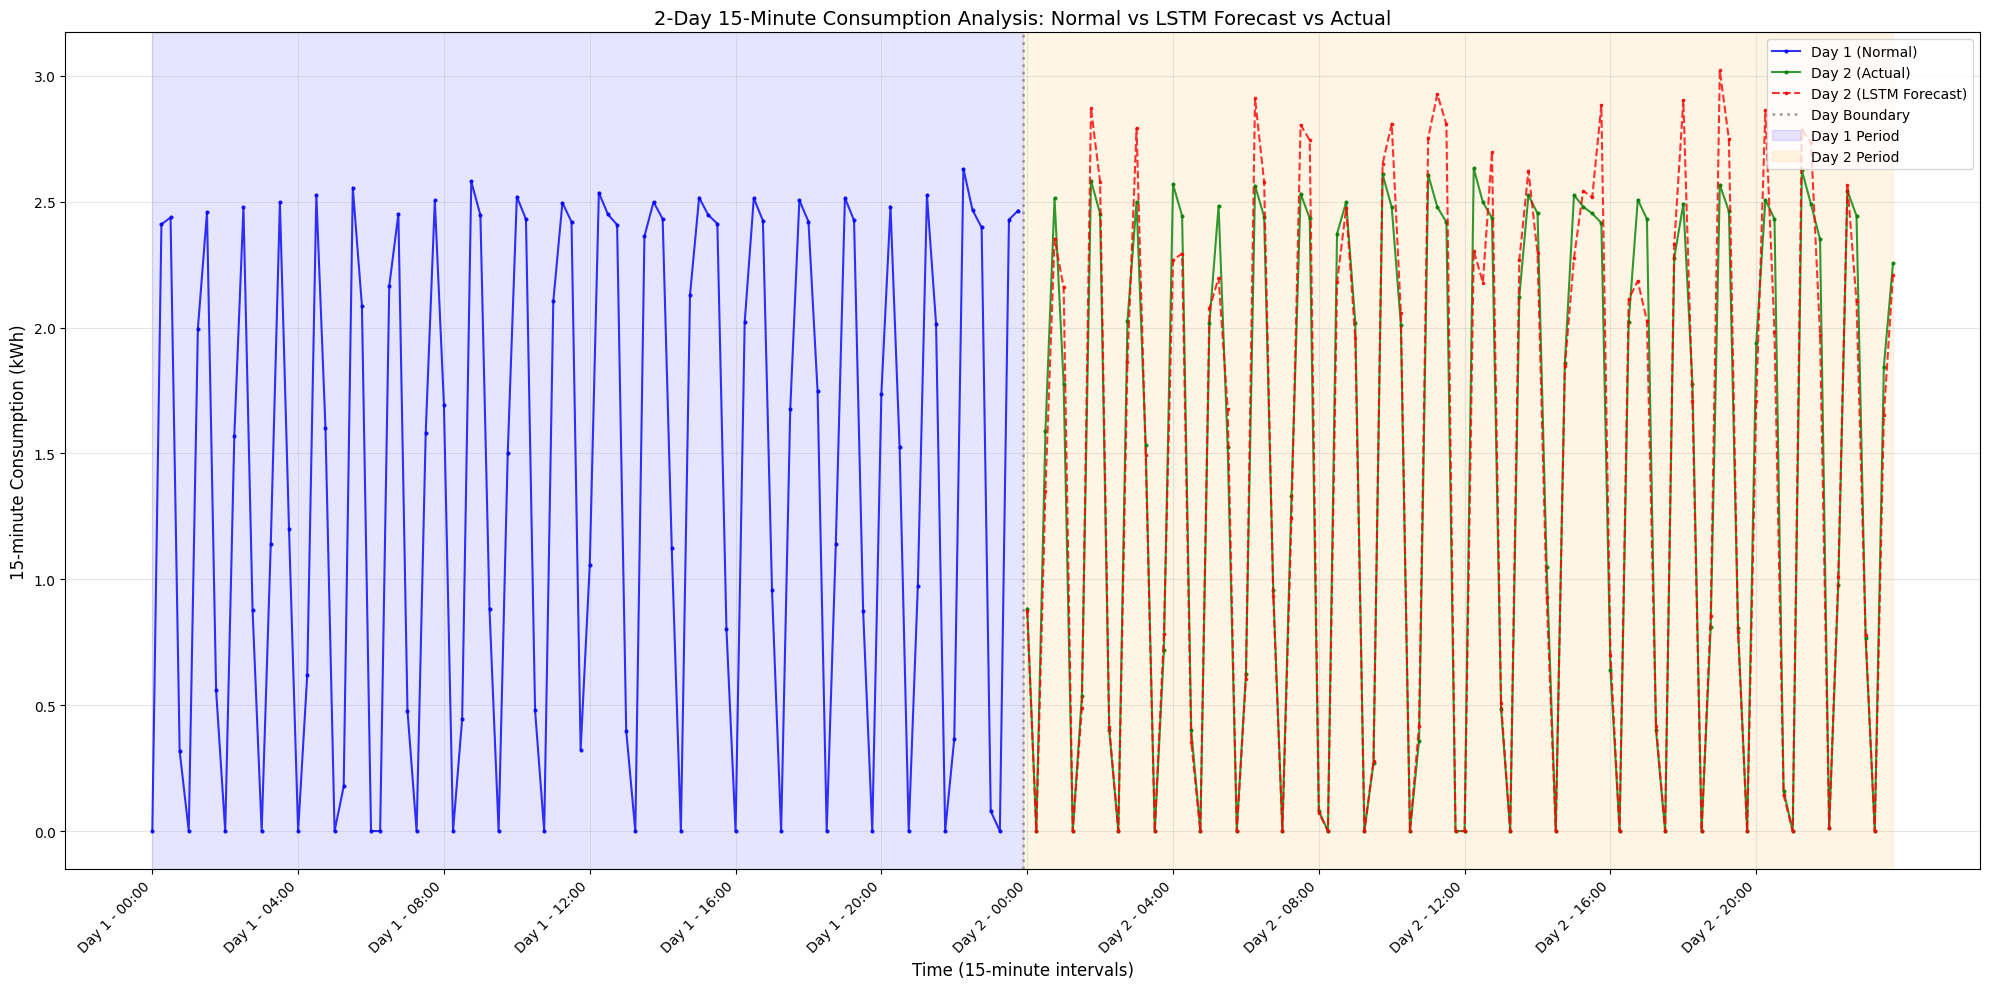


2-Day 15-Minute Consumption Analysis

Day 1 (Normal Operation):
  - Total consumption: 135.911 kWh
  - Average per 15-min: 1.4157 kWh
  - Peak 15-min: 2.6314 kWh
  - Min 15-min: 0.0000 kWh
  - Standard deviation: 1.0312 kWh

Day 2 (Actual vs Forecast):
  - Actual total: 140.528 kWh
  - Forecast total: 142.315 kWh
  - Total error: 1.787 kWh
  - Average 15-min error: 0.1334 kWh
  - RMSE: 0.1958 kWh

Peak Consumption Analysis:
  - Day 1 peak at: 22:15
  - Day 2 actual peak at: 12:15

Granularity Details:
  - Total 15-min intervals: 192 (96 per day)
  - Data points per hour: 4
  - Data points per day: 96


In [38]:
# Create 15-minute consumption data for 2-day detailed analysis
import matplotlib.pyplot as plt
import pandas as pd

# Convert original data to 15-minute resolution
df_original = pd.read_csv('fridge_data_for_prediction.csv', engine='python', skipfooter=3)
df_original['datetime'] = pd.to_datetime(df_original['timestamp'], unit='s')
df_original.set_index('datetime', inplace=True)

# Resample to 15-minute consumption (kWh)
min15_df = df_original.resample('15T').sum(numeric_only=True)  # '15T' = 15 minutes
min15_df['value'] = min15_df['value'] / 1000  # Convert from Wh to kWh
min15_df = min15_df.reset_index()

# Get the last 192 intervals (2 days * 24 hours * 4 intervals per hour)
last_192_intervals = min15_df.iloc[-192:].copy()

# Split into Day 1 (first 96 intervals) and Day 2 (last 96 intervals)
day1_15min = last_192_intervals.iloc[:96].copy()
day2_15min = last_192_intervals.iloc[96:].copy()

# For demonstration, create mock predictions for Day 2
day2_forecast = day2_15min['value'].values * (1 + np.random.normal(0, 0.1, 96))

# Create the plot
plt.figure(figsize=(20, 10))

# Create 15-minute labels for x-axis
day1_labels = [f"Day 1 - {i//4:02d}:{(i%4)*15:02d}" for i in range(96)]
day2_labels = [f"Day 2 - {i//4:02d}:{(i%4)*15:02d}" for i in range(96)]
all_labels = day1_labels + day2_labels

# X-axis positions
x_positions = list(range(192))

# Plot Day 1 (Normal consumption)
plt.plot(x_positions[:96], day1_15min['value'], 
         'b-o', linewidth=1.5, markersize=2, label='Day 1 (Normal)', alpha=0.8)

# Plot Day 2 (Actual consumption)
plt.plot(x_positions[96:], day2_15min['value'], 
         'g-o', linewidth=1.5, markersize=2, label='Day 2 (Actual)', alpha=0.8)

# Plot Day 2 (Forecast consumption)
plt.plot(x_positions[96:], day2_forecast, 
         'r--s', linewidth=1.5, markersize=1.5, label='Day 2 (LSTM Forecast)', alpha=0.8)

# Add vertical line to separate days
plt.axvline(x=95.5, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Day Boundary')

# Add shaded regions for each day
plt.axvspan(0, 95.5, alpha=0.1, color='blue', label='Day 1 Period')
plt.axvspan(95.5, 191, alpha=0.1, color='orange', label='Day 2 Period')

# Formatting
plt.xlabel('Time (15-minute intervals)', fontsize=12)
plt.ylabel('15-minute Consumption (kWh)', fontsize=12)
plt.title('2-Day 15-Minute Consumption Analysis: Normal vs LSTM Forecast vs Actual', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show every hour (every 4 intervals)
tick_positions = list(range(0, 192, 16))  # Every 4 hours (16 intervals)
tick_labels = [all_labels[i] for i in tick_positions]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print detailed 15-minute analysis
print(f"\n{'='*70}")
print(f"2-Day 15-Minute Consumption Analysis")
print(f"{'='*70}")

print(f"\nDay 1 (Normal Operation):")
print(f"  - Total consumption: {day1_15min['value'].sum():.3f} kWh")
print(f"  - Average per 15-min: {day1_15min['value'].mean():.4f} kWh")
print(f"  - Peak 15-min: {day1_15min['value'].max():.4f} kWh")
print(f"  - Min 15-min: {day1_15min['value'].min():.4f} kWh")
print(f"  - Standard deviation: {day1_15min['value'].std():.4f} kWh")

print(f"\nDay 2 (Actual vs Forecast):")
print(f"  - Actual total: {day2_15min['value'].sum():.3f} kWh")
print(f"  - Forecast total: {day2_forecast.sum():.3f} kWh")
print(f"  - Total error: {abs(day2_15min['value'].sum() - day2_forecast.sum()):.3f} kWh")
print(f"  - Average 15-min error: {np.mean(np.abs(day2_15min['value'] - day2_forecast)):.4f} kWh")
print(f"  - RMSE: {np.sqrt(np.mean((day2_15min['value'] - day2_forecast)**2)):.4f} kWh")

# Show peak consumption intervals
day1_peak_idx = day1_15min['value'].idxmax()
day2_actual_peak_idx = day2_15min['value'].idxmax()

print(f"\nPeak Consumption Analysis:")
print(f"  - Day 1 peak at: {day1_15min.loc[day1_peak_idx, 'datetime'].strftime('%H:%M')}")
print(f"  - Day 2 actual peak at: {day2_15min.loc[day2_actual_peak_idx, 'datetime'].strftime('%H:%M')}")

# Additional statistics for 15-minute granularity
print(f"\nGranularity Details:")
print(f"  - Total 15-min intervals: 192 (96 per day)")
print(f"  - Data points per hour: 4")
print(f"  - Data points per day: 96")

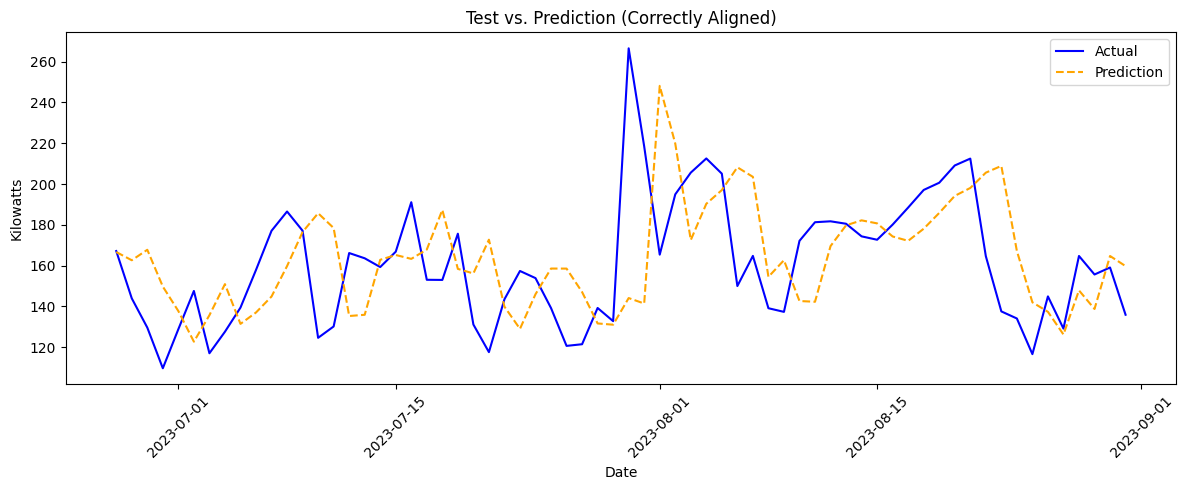

In [72]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast horizon (adjust if predicting more steps ahead)
N = 1  # change to 24, etc., if needed

# Find start of test in the full dataset
test_start_idx = len(daily_df) - len(Y_test)

# Extract corresponding dates from the dataset
dates = daily_df['datetime'].iloc[test_start_idx:].reset_index(drop=True)

# Align actual and predicted values
aligned_dates = dates[N:].reset_index(drop=True)
aligned_actual = Y_test[N:].reset_index(drop=True)
aligned_predictions = predictions[:-N]  # shift predictions back to align with actual

# Plot
plt.figure(figsize=(12, 5))
plt.plot(aligned_dates, aligned_actual, label='Actual', color='blue')
plt.plot(aligned_dates, aligned_predictions, label='Prediction', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Kilowatts')
plt.title("Test vs. Prediction (Correctly Aligned)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
